What are the expected changes in m5 with airmass, given our current scaling relationships for skybrightness and seeing?

Current m5 calculation (from sims_operations https://github.com/lsst/sims_operations/blob/master/tools/schema_tools/gen_output.py) and also written out in SMTN-002 (http://smtn-002.lsst.io/en/latest/)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def calc_m5(visitFilter, filtsky, FWHMeff, expTime, airmass, tauCloud=0):
    # Set up expected extinction (kAtm) and m5 normalization values (Cm) for each filter.
    # The Cm values must be changed when telescope and site parameters are updated.
    #
    # These values are calculated using $SYSENG_THROUGHPUTS/python/calcM5.py.
    # This set of values are calculated using v1.0 of the SYSENG_THROUGHPUTS repo.
    Cm = {'u':22.94,
          'g':24.46,
          'r':24.48,
          'i':24.34,
          'z':24.18,
          'y':23.73}
    dCm_infinity = {'u':0.56,
                    'g':0.12,
                    'r':0.06,
                    'i':0.05,
                    'z':0.03,
                    'y':0.02}
    kAtm = {'u':0.50,
            'g':0.21,
            'r':0.13,
            'i':0.10,
            'z':0.07,
            'y':0.18}
    msky = {'u':22.95,
            'g':22.24,
            'r':21.20,
            'i':20.47,
            'z':19.60,
            'y':18.63}
    # Calculate adjustment if readnoise is significant for exposure time
    # (see overview paper, equation 7)
    Tscale = expTime / 30.0 * np.power(10.0, -0.4*(filtsky - msky[visitFilter]))
    dCm = dCm_infinity[visitFilter] - 1.25*np.log10(1 + (10**(0.8*dCm_infinity[visitFilter]) - 1)/Tscale)
    # Calculate fiducial m5
    m5 = (Cm[visitFilter] + dCm + 0.50*(filtsky-21.0) + 2.5*np.log10(0.7/FWHMeff) +
          1.25*np.log10(expTime/30.0) - kAtm[visitFilter]*(airmass-1.0) + 1.1*tauCloud)
    return m5

At a given moment, we have a raw seeing @ zenith value, and a zenith skybrightness. How do these scale with airmass?

In [6]:
def calc_FWHMeff(visitFilter, rawSeeing, airmass):
    filterWave = {'u': 367.0, 'g': 482.5, 'r': 622.2, 'i': 754.5, 'z': 869.1, 'y': 971.0}
    telSeeing = 0.25
    opticalDesign = 0.08
    cameraSeeing = 0.30
    fwhm_sys = np.sqrt(telSeeing**2 + opticalDesign**2 + cameraSeeing**2) * np.power(airmass, 0.6)
    fwhm_atm = rawSeeing * np.power(500.0 / filterWave[visitFilter], 0.3) * np.power(airmass, 0.6)
    fwhmEff = 1.16 * np.sqrt(fwhm_sys**2 + 1.04*fwhm_atm**2)
    return fwhmEff

In [7]:
def calc_FWHMeff_enigma(visitFilter, rawSeeing, airmass):
    filterWave = {'u': 350.0, 'g': 520.0, 'r': 670.0, 'i': 790.0, 'z': 1000.0, 'y': 1040.0}
    telSeeing = 0.25
    opticalDesign = 0.08
    cameraSeeing = 0.30
    fwhm_sys = np.sqrt(telSeeing**2 * np.power(airmass, 0.6) + opticalDesign**2 + cameraSeeing**2)
    fwhm_atm = rawSeeing * np.power(500.0 / filterWave[visitFilter], 0.2) * np.power(airmass, 0.6)
    fwhmEff = np.sqrt(fwhm_sys**2 + fwhm_atm**2)
    return fwhmEff

In [8]:
def calc_skybright(zenithSky, airmass):
    # Do this in the way which matches opsim, in dark sky. 
    # Since their skybrightness per filter does not depend on airmass, just ignore the filter offset.
    # And their skybrightness then only depends on the zenith sky value, scaled by X * 10^(-.4*k*(X-1))
    extinction = 0.172
    skyBright = np.power(10, -0.4 * zenithSky) * airmass * np.power(10, -0.4 * extinction * (airmass - 1.))
    skyBright = -2.5 * np.log10(skyBright)
    return skyBright

In [9]:
def plot_sky(visitFilter, rawSeeing, zenithSky, airmass):
    fwhmeff = calc_FWHMeff(visitFilter, rawSeeing, airmass)
    fwhmeff_old = calc_FWHMeff_enigma(visitFilter, rawSeeing, airmass)
    skybright = calc_skybright(zenithSky, airmass)
    m5 = calc_m5(visitFilter, skybright, fwhmeff, 30.0, airmass)
    m5_old = calc_m5(visitFilter, skybright, fwhmeff_old, 30.0, airmass)
    plt.figure(figsize=(8, 6))
    plt.plot(airmass, m5, 'b')
    plt.plot(airmass, m5_old, 'r')
    plt.xlabel('Airmass')
    plt.ylabel('m5')
    plt.title("Expected change in m5 with airmass, %s band" % visitFilter)
    plt.xlim(1.0, 2.0)
    plt.gca().invert_yaxis()
    return m5

In [10]:
msky = {'u': 22.95, 'g': 22.24, 'r': 21.20,
        'i': 20.47, 'z': 19.60, 'y': 18.63}
airmass = np.arange(1.0, 2.0, 0.1)
rawSeeing = 0.68
srd_m5_design = {'u': 23.9, 'g': 25.0, 'r': 24.7, 'i': 24.0, 'z': 23.3, 'y': 22.1}
srd_m5_min = {'u': 23.4, 'g': 24.6, 'r': 24.3, 'i': 23.6, 'z': 22.9, 'y': 21.7}
syseng_m5 = {'u': 23.62, 'g': 24.85, 'r': 24.39, 'i': 23.94, 'z': 23.36, 'y': 22.45}

These m5 values calculated below are using the 'fiducial' sky values above, which are not really correct for our expected darksky values. I also assigned the rawSeeing randomly. Both of them should be reasonably in the ballpark though (checking against srd_m5 and syseng_m5). 

It means that the *range* of values produced as a function of airmass are probably not unreasonable.

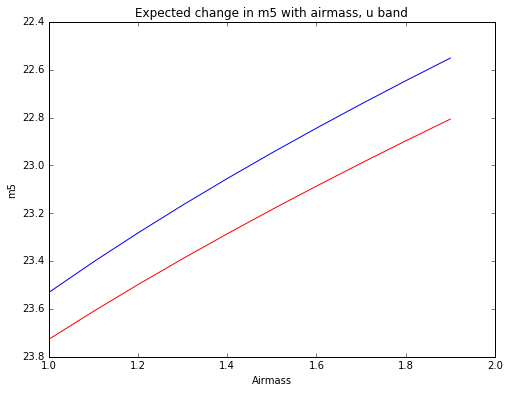

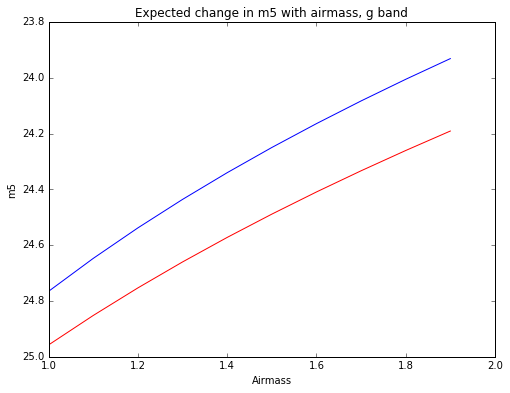

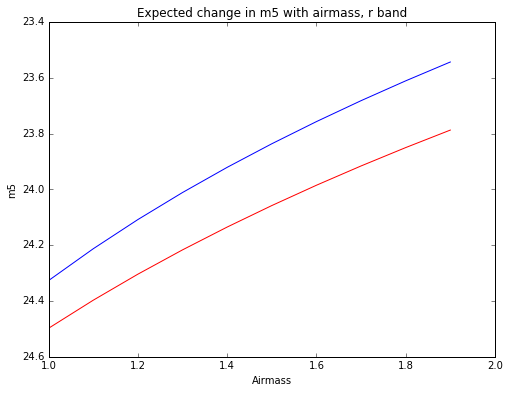

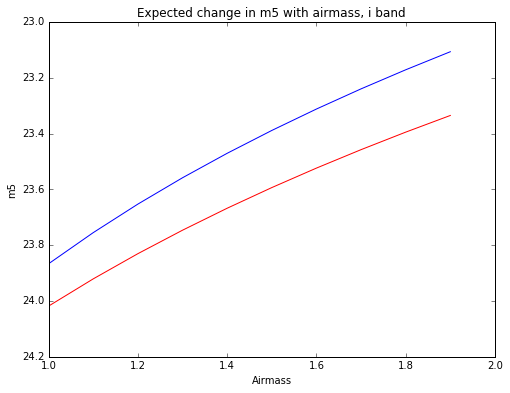

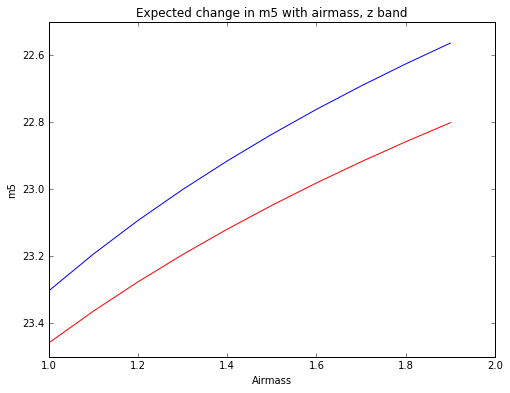

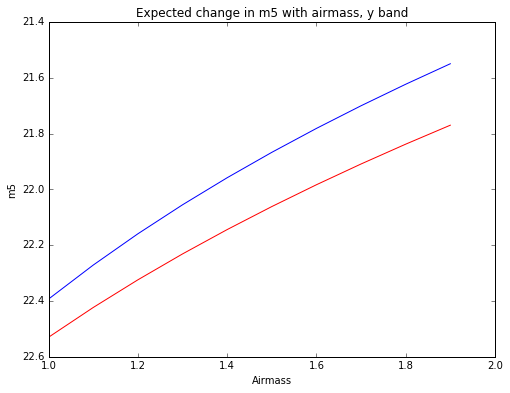

In [11]:
m5 = {}
for visitFilter in ('u', 'g', 'r', 'i', 'z', 'y'):
    zenithSky = msky[visitFilter]
    m5[visitFilter] = plot_sky(visitFilter, rawSeeing, zenithSky, airmass)

In [60]:
for f in ('u', 'g', 'r', 'i', 'z', 'y'):
    print f, srd_m5_min[f], syseng_m5[f], m5[f].max(), m5[f].max() - srd_m5_min[f], m5[f].max() - syseng_m5[f]

u 23.4 23.62 23.5316474099 0.131647409917 -0.0883525900825
g 24.6 24.85 24.7653027428 0.165302742812 -0.0846972571878
r 24.3 24.39 24.326688865 0.0266888649957 -0.0633111350043
i 23.6 23.94 23.8665670737 0.266567073748 -0.0734329262521
z 22.9 23.36 23.3035222777 0.403522277745 -0.0564777222548
y 21.7 22.45 22.3929884969 0.692988496947 -0.0570115030527


In [71]:
airIdx = 1
airIdx2 = 6
print 'between airmasses of ', airmass[airIdx], airmass[airIdx2]
print ' find a range of m5 of:'
for f in  ('u', 'g', 'r', 'i', 'z', 'y'):
    print f, m5[f][airIdx] - m5[f][airIdx2]

between airmasses of  1.1 1.6
 find a range of m5 of:
u 0.559898579576
g 0.483034852675
r 0.455798700241
i 0.443016546785
z 0.432530822117
y 0.489827440482
